<a href="https://colab.research.google.com/github/Smatwah/NLP-smatwah/blob/main/NLP_SULAIMAN_ALATWAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers arabert pytorch-lightning
!pip install -U transformers

In [14]:
import pandas as pd
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [15]:
file_path = '/content/commercial_names_2018.csv'
df = pd.read_csv(file_path)
df = df[['Commercial_Name', 'Activity_Label']].dropna()
df.head(10)

,Commercial_Name,Activity_Label
0,مطعم ابراهيم فهد محمد الطريفي لتقديم الوجبات,مطاعم
1,مؤسسة نبيل سامى بن محمد مكى الكتبي للخط والرسم,تصميم/فنون
2,بوفية منارة القريات الذهبية للوجبات السريعة,مطاعم
3,مطاعم داجن المميز للوجبات السريعة,مطاعم
4,مؤسسة فالح معزي سعود الشمري للصيانة,صيانة
5,محل نجم القهوة العربية التجارية,مقاهي
6,مصنع رهام رفيدى يحي قحاص للصناعة,تصنيع
7,مكتب نوال سلطان بن بدر الغربي التجارية,خدمات مكتبية
8,مصنع نوره حمود بن عقاب الحمادي للصناعة,تصنيع
9,مؤسسة إم إس جي للنقل البحري و الخدمات اللوجيستيه,نقل


In [16]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Activity_Label'])

In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Commercial_Name'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [18]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02", use_fast=False)

In [20]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

In [19]:
class CRDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CRDataset(train_encodings, train_labels)
val_dataset = CRDataset(val_encodings, val_labels)

In [21]:
num_labels = len(set(train_labels))
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv02",
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    report_to=[]
)



In [29]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}
    import os
os.environ["WANDB_DISABLED"] = "true"
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
500,0.046000


TrainOutput(global_step=711, training_loss=0.036582234874891664, metrics={'train_runtime': 3821.8784, 'train_samples_per_second': 2.973, 'train_steps_per_second': 0.186, 'total_flos': 110962787241024.0, 'train_loss': 0.036582234874891664, 'epoch': 1.0})

In [30]:
model.save_pretrained("./arabert_cr_model")
tokenizer.save_pretrained("./arabert_cr_model")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [31]:
!pip install gradio

In [9]:
# Artistic Gradio App Design – Elegant Colors & Creative Layout
import gradio as gr
import torch
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

# Load model, tokenizer, and label encoder
model = AutoModelForSequenceClassification.from_pretrained("./arabert_cr_model")
tokenizer = AutoTokenizer.from_pretrained("./arabert_cr_model")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Prediction function
def predict_activity(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = outputs.logits.argmax(dim=1).item()
        label = le.inverse_transform([pred])[0]
    return label

# Static Accuracy Plot
def plot_accuracy():
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar(["Accuracy"], [0.9980], color="#6C5CE7")
    ax.set_ylim(0.95, 1.01)
    ax.set_title("Model Accuracy", fontsize=14, fontweight='bold', color="#6C5CE7")
    for i, v in enumerate([0.9980]):
        ax.text(i, v + 0.001, f"{v:.4f}", ha='center', fontweight='bold', color="#00b894")
    return fig

# Custom CSS for colorful and elegant UI
custom_css = """
body {
    background: linear-gradient(135deg, #fdfcfb, #e2d1c3);
    font-family: 'Poppins', sans-serif;
}
.gr-button {
    background: linear-gradient(45deg, #6C5CE7, #00b894);
    color: white !important;
    border-radius: 15px;
    font-size: 16px;
    padding: 14px 24px;
    transition: all 0.4s ease-in-out;
    box-shadow: 0 4px 15px rgba(0,0,0,0.2);
    border: none;
}
.gr-button:hover {
    transform: scale(1.05);
    background: linear-gradient(45deg, #00b894, #6C5CE7);
    box-shadow: 0 6px 20px rgba(0,0,0,0.3);
}
.card {
    background-color: #ffffffdd;
    border-radius: 20px;
    padding: 30px;
    margin: 10px;
    box-shadow: 0 8px 20px rgba(0,0,0,0.1);
    transition: 0.3s ease-in-out;
}
.card:hover {
    box-shadow: 0 12px 24px rgba(0,0,0,0.2);
    transform: translateY(-4px);
}
"""

# Gradio app with artistic layout
with gr.Blocks(css=custom_css, theme=gr.themes.Default()) as demo:
    gr.Markdown("""
    <div class="card">
    <h1 style="color:#6C5CE7;">Business Name Classifier</h1>
    <p style="font-size:16px; color:#2d3436;">
    Discover what category your commercial name belongs to using our AI-powered Arabic BERT classifier.
    </p>
    </div>
    """)

    with gr.Row():
        btn_try = gr.Button("🚀 Try the App")
        btn_acc = gr.Button("📊 Show Accuracy")

    with gr.Row(visible=False) as page_try:
        gr.Markdown("<div class='card'><h2 style='color:#00b894;'>Try the App</h2></div>")
        input_text = gr.Textbox(label="Business Name", placeholder="e.g., Al Riyadh Restaurant")
        output_text = gr.Textbox(label="Predicted Category")
        btn_submit = gr.Button("Predict")
        back_btn_1 = gr.Button("⬅️ Back")
        btn_submit.click(fn=predict_activity, inputs=input_text, outputs=output_text)

    with gr.Row(visible=False) as page_acc:
        gr.Markdown("<div class='card'><h2 style='color:#6C5CE7;'>📊 Model Accuracy</h2></div>")
        acc_plot = gr.Plot()
        btn_show_acc = gr.Button("Show Accuracy Plot")
        back_btn_2 = gr.Button("⬅️ Back")
        btn_show_acc.click(fn=plot_accuracy, outputs=acc_plot)

    # Toggle visibility
    def go_to_try(): return gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)
    def go_to_acc(): return gr.update(visible=False), gr.update(visible=True), gr.update(visible=False)
    def go_home(): return gr.update(visible=False), gr.update(visible=False), gr.update(visible=True)

    hidden_home = gr.Row(visible=True)
    btn_try.click(go_to_try, outputs=[page_try, page_acc, hidden_home])
    btn_acc.click(go_to_acc, outputs=[page_try, page_acc, hidden_home])
    back_btn_1.click(go_home, outputs=[page_try, page_acc, hidden_home])
    back_btn_2.click(go_home, outputs=[page_try, page_acc, hidden_home])

# Launch
if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://11620c0ca512617f19.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


✅ Accuracy: 0.9989


<Figure size 1000x800 with 0 Axes>

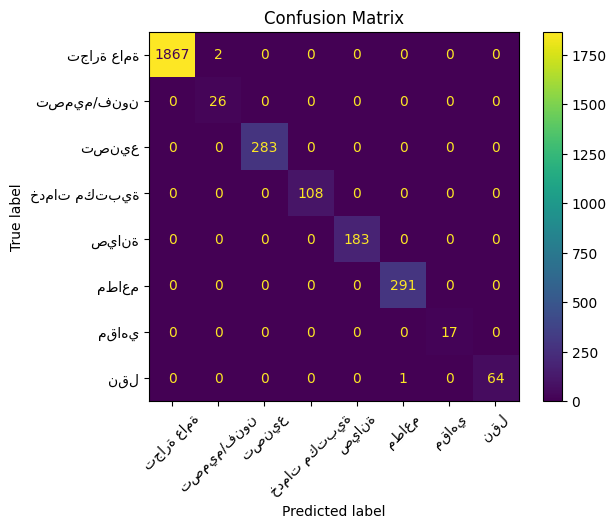

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

val_inputs = tokenizer(val_texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
val_dataset_encodings = CRDataset(val_inputs, val_labels)

preds_output = trainer.predict(val_dataset_encodings)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

acc = accuracy_score(y_true, y_preds)
print(f"✅ Accuracy: {acc:.4f}")

labels = le.classes_
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
